In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from glob import glob
from src.data.handlers import DataLoader
from src.models.regression.train_models import RegressionTraining
from src.utils import denorm
from src.utils.constants import FEATURES_NAMES, FLUID_COMPONENTS

In [2]:
data_loader = DataLoader()
datasets, min_max = data_loader.load_cross_validation_datasets(problem="regression")

valid_datasets = datasets["valid"]
training = RegressionTraining()
results = training.load_training_models()

In [10]:
def absolute_error(y_true: np.ndarray, y_pred: np.ndarray):
    return np.abs(y_true - y_pred)

# Regression models
model = [m for m in results["outputs"] if m["model_id"] == 13][0]

# Regression models with soft constraint on loss function
constrained_models = [None for _ in range(4)]
folder = os.path.join("data", "models", "regression_with_constrained_loss", "saved_results")
for model_filepath in glob(os.path.join(folder, "*model_id=3*.keras")):
    _, model_filename = os.path.split(model_filepath)
    fold_index = int(model_filename[27])
    constrained_models[fold_index] = tf.keras.models.load_model(model_filepath)

indices = {
    "model": {
        "x_hats": np.zeros((4, 19, 24)),
        "y_hats": np.zeros((4, 19, 24)),
        "x_error": np.zeros((4, 19, 24)),
        "y_error": np.zeros((4, 19, 24)),
        "nV_error": np.zeros((4, 19)),
    },
    "constrained_model": {
        "x_hats": np.zeros((4, 19, 24)),
        "y_hats": np.zeros((4, 19, 24)),
        "x_error": np.zeros((4, 19, 24)),
        "y_error": np.zeros((4, 19, 24)),
        "nV_error": np.zeros((4, 19)),
    }
}

for i, (result, valid_data) in enumerate(zip(model["folds"], valid_datasets)):
    valid_features, valid_labels = valid_data["features"], valid_data["targets"]

    z = valid_features.loc[:, FEATURES_NAMES[:-2]].values

    X_valid = tf.convert_to_tensor(valid_features)
    Y_valid = denorm(valid_labels.to_numpy(), *min_max[i])
    K = Y_valid[:, :-1]
    nV = Y_valid[:, -1:]
    x = z / (1 + nV * (K - 1))
    y = K * x

    # Regression models
    model = result["model"]

    Y_hat_valid = denorm(model(X_valid).numpy(), *min_max[i])
    K_hat = Y_hat_valid[:, :-1]
    nV_hat = Y_hat_valid[:, -1:]
    x_hat = z / (1 + nV_hat * (K_hat - 1))
    y_hat = K_hat * x_hat

    indices["model"]["x_hats"][i, :, :] = x_hat
    indices["model"]["y_hats"][i, :, :] = y_hat
    indices["model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["model"]["y_error"][i, :, :] = absolute_error(y, y_hat)
    indices["model"]["nV_error"][i, :] = absolute_error(nV, nV_hat).flatten()

    # Regression with soft constraint models
    constrained_model = constrained_models[i]

    Y_hat_valid = denorm(constrained_model(X_valid).numpy(), *min_max[i])
    K_hat = Y_hat_valid[:, :-1]
    nV_hat = Y_hat_valid[:, -1:]
    x_hat = z / (1 + nV_hat * (K_hat - 1))
    y_hat = K_hat * x_hat

    indices["constrained_model"]["x_hats"][i, :, :] = x_hat
    indices["constrained_model"]["y_hats"][i, :, :] = y_hat
    indices["constrained_model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["constrained_model"]["x_error"][i, :, :] = absolute_error(x, x_hat)
    indices["constrained_model"]["y_error"][i, :, :] = absolute_error(y, y_hat)
    indices["constrained_model"]["nV_error"][i, :] = absolute_error(nV, nV_hat).flatten()

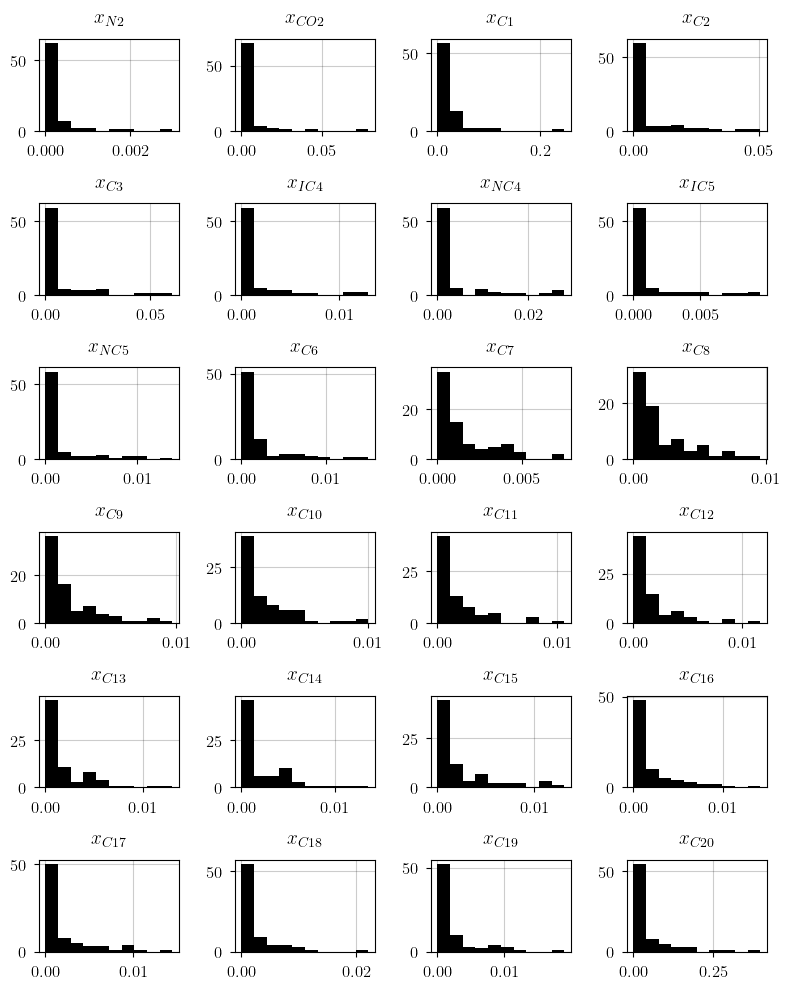

In [4]:
f, axs = plt.subplots(6, 4, figsize=(8, 10))

for i in range(indices["model"]["x_error"].shape[2]):
    ax = axs[i//4, i%4]
    ax.hist(indices["model"]["x_error"][:,:,i].flatten())

    title = "$x_{{{}}}$"
    ax.set_title(title.format(FLUID_COMPONENTS[i]))
    ax.grid()
f.tight_layout()

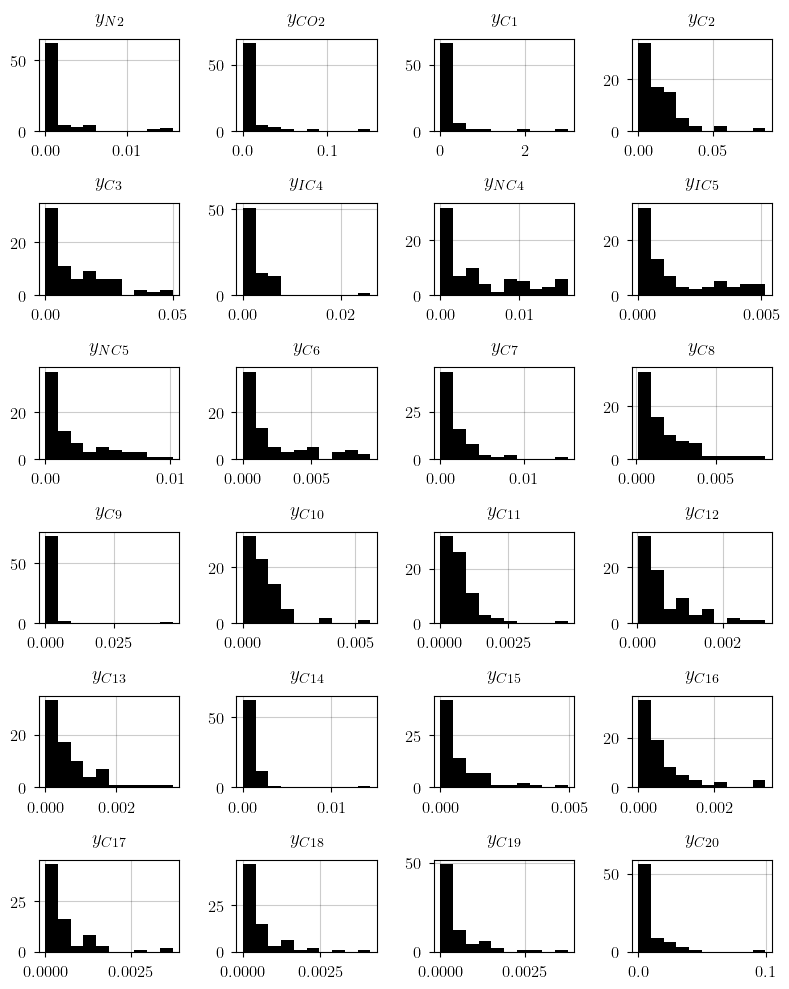

In [5]:
f, axs = plt.subplots(6, 4, figsize=(8, 10))

for i in range(indices["model"]["y_error"].shape[2]):
    ax = axs[i//4, i%4]
    ax.hist(indices["model"]["y_error"][:,:,i].flatten())

    title = "$y_{{{}}}$"
    ax.set_title(title.format(FLUID_COMPONENTS[i]))
    ax.grid()
f.tight_layout()

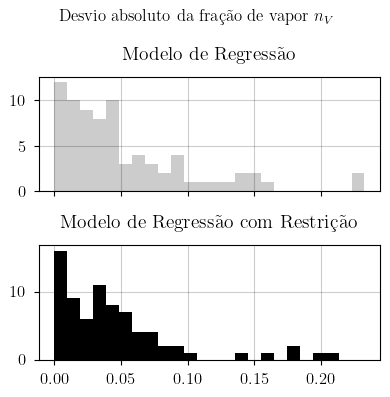

In [26]:
nV_error_vec = indices["model"]["nV_error"].flatten()
bins = np.linspace(nV_error_vec.min(), nV_error_vec.max(), num=25)

f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 4))
axs[0].hist(indices["model"]["nV_error"].flatten(), bins=bins, alpha=0.2)
axs[1].hist(indices["constrained_model"]["nV_error"].flatten(), bins=bins)
axs[0].set_title("Modelo de Regressão")
axs[1].set_title("Modelo de Regressão com Restrição")

for ax in axs:
    ax.grid()

f.suptitle("Desvio absoluto da fração de vapor $n_V$")
f.tight_layout()

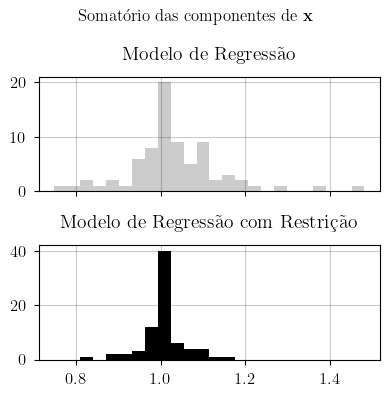

In [25]:
x_hat_vec = indices["model"]["x_hats"].sum(axis=2).flatten()
bins = np.linspace(x_hat_vec.min(), x_hat_vec.max(), num=25)

f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 4))
axs[0].hist(indices["model"]["x_hats"].sum(axis=2).flatten(), bins=bins, alpha=0.2)
axs[1].hist(indices["constrained_model"]["x_hats"].sum(axis=2).flatten(), bins=bins)
axs[0].set_title("Modelo de Regressão")
axs[1].set_title("Modelo de Regressão com Restrição")

for ax in axs:
    ax.grid()

f.suptitle("Somatório das componentes de $\\mathbf{x}$")
f.tight_layout()

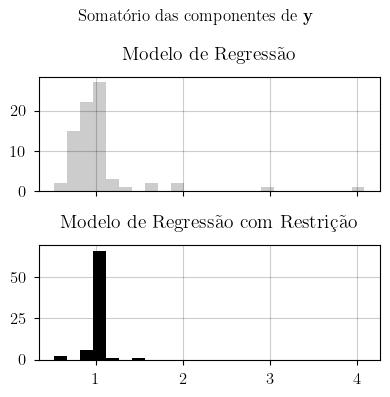

In [21]:
y_hat_vec = indices["model"]["y_hats"].sum(axis=2).flatten()
bins = np.linspace(y_hat_vec.min(), y_hat_vec.max(), num=25)

f, axs = plt.subplots(2, 1, sharex=True, figsize=(4, 4))
axs[0].hist(indices["model"]["y_hats"].sum(axis=2).flatten(), bins=bins, alpha=0.2)
axs[1].hist(indices["constrained_model"]["y_hats"].sum(axis=2).flatten(), bins=bins)
axs[0].set_title("Modelo de Regressão")
axs[1].set_title("Modelo de Regressão com Restrição")

for ax in axs:
    ax.grid()

f.suptitle("Somatório das componentes de $\\mathbf{y}$")
f.tight_layout()